import relevant libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

Load Dataset

In [7]:
# Define a transform to convert images to tensors
transform = transforms.ToTensor()

# Load the MNIST dataset
mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

indices = (mnist_train_data.targets == 5) | (mnist_train_data.targets == 1) | (mnist_train_data.targets == 7)
mnist_train_data.data, mnist_train_data.targets = mnist_train_data.data[indices], mnist_train_data.targets[indices]

# Create data loaders to load the data in batches
data_loader = torch.utils.data.DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset=mnist_test_data, batch_size=10000, shuffle=False)

Define Autoencoder

In [8]:
# This is the definition of the Autoencoder model using a neural network with encoder and decoder modules.
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 100),
        )

        self.decoder = nn.Sequential(
            nn.Linear(100, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Train model

In [9]:
# These lines define the loss function (MSE loss), instantiate the Autoencoder model
# learning rate of 1e-3 and L2 regularization with a weight decay of 1e-5.
criterion = nn.MSELoss()
model = Autoencoder2()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-10, momentum=0.9)

# train the model over n epochs
num_epochs = 100
encPics = []
labels = []
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28 * 28)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0579
Epoch:2, Loss:0.0492
Epoch:3, Loss:0.0524
Epoch:4, Loss:0.0512
Epoch:5, Loss:0.0511
Epoch:6, Loss:0.0486
Epoch:7, Loss:0.0464
Epoch:8, Loss:0.0494
Epoch:9, Loss:0.0468
Epoch:10, Loss:0.0378
Epoch:11, Loss:0.0432
Epoch:12, Loss:0.0432
Epoch:13, Loss:0.0452
Epoch:14, Loss:0.0401
Epoch:15, Loss:0.0394
Epoch:16, Loss:0.0348
Epoch:17, Loss:0.0347
Epoch:18, Loss:0.0355
Epoch:19, Loss:0.0343
Epoch:20, Loss:0.0335
Epoch:21, Loss:0.0335
Epoch:22, Loss:0.0328
Epoch:23, Loss:0.0313
Epoch:24, Loss:0.0314
Epoch:25, Loss:0.0257
Epoch:26, Loss:0.0278
Epoch:27, Loss:0.0287
Epoch:28, Loss:0.0274
Epoch:29, Loss:0.0265
Epoch:30, Loss:0.0233
Epoch:31, Loss:0.0251
Epoch:32, Loss:0.0239
Epoch:33, Loss:0.0253
Epoch:34, Loss:0.0246
Epoch:35, Loss:0.0218
Epoch:36, Loss:0.0222
Epoch:37, Loss:0.0232
Epoch:38, Loss:0.0216
Epoch:39, Loss:0.0222
Epoch:40, Loss:0.0205
Epoch:41, Loss:0.0198
Epoch:42, Loss:0.0215
Epoch:43, Loss:0.0182
Epoch:44, Loss:0.0214
Epoch:45, Loss:0.0173
Epoch:46, Loss:0.01

Run Random Forest Classifier on encoded data

In [10]:
for (img, l) in data_loader_test:
    item = img.reshape(-1, 28 * 28)
    enc = model.encoder(item)
    enc = enc.detach().numpy()
    l = l.detach().numpy()
    encPics.append(enc)
    labels.append(l)

rf = RandomForestClassifier(n_estimators=266, max_depth=11)
encPics = np.reshape(encPics, (-1, 100))
labels = np.reshape(labels, (-1, 1))
labels = labels.ravel()
rf.fit(encPics, labels)
y_pred_1 = rf.predict(encPics)

accscore = accuracy_score(labels, y_pred_1, normalize=True)
print(accscore)

print(classification_report(labels, y_pred_1))

0.9405
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.89      0.90      0.89      1010
           4       0.90      0.94      0.92       982
           5       0.97      0.90      0.94       892
           6       0.93      0.97      0.95       958
           7       0.99      0.97      0.98      1028
           8       0.89      0.89      0.89       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



Plot the reconstructed pictures

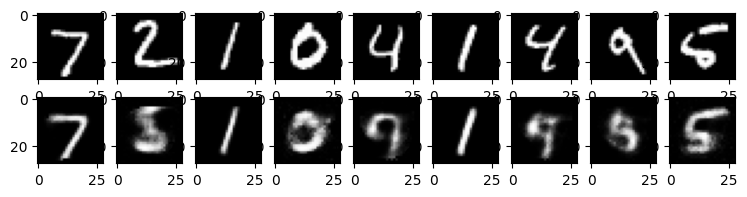

In [11]:
# Plot the resulting images
#for k in range(0, num_epochs, 10):
plt.figure(figsize=(9, 2))
plt.gray()

reconPics = []
imgs = []
for (img, _) in data_loader_test:
    item = img.reshape(-1, 28 * 28)
    recon = model(item)
    reconPics = recon
    imgs = img

for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i + 1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

for i, item in enumerate(reconPics):
    if i >= 9: break
    plt.subplot(2, 9, 9 + i + 1)
    item = item.reshape(-1, 28, 28)
    plt.imshow((item.detach().numpy())[0])

plt.show()